<a href="https://colab.research.google.com/github/sardarabdulsammad/DeepLearning/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#02. Neural Network classification with Pytorch

##1. Making Classification data and get it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

In [2]:
n_samples = 1000

#creates circles
X,Y = make_circles(n_samples, noise = 0.03, random_state=42)

In [3]:
len(X), len(Y) , X[:5], Y[:5]

(1000,
 1000,
 array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

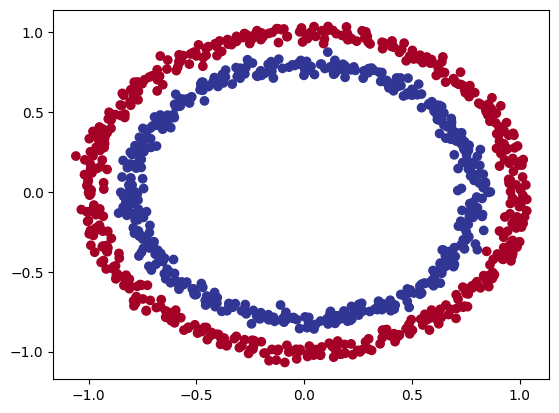

In [4]:
#Visualize

import matplotlib.pyplot as plt
plt.scatter(x = X[:,0],
            y = X[:,1],
            c= Y,
            cmap = plt.cm.RdYlBu)

### 1.1 Check Input and output shapes

In [5]:
X.shape, Y.shape

((1000, 2), (1000,))

In [6]:
# View the first example of features and labels
X_sample = X[0]
Y_sample = Y[0]

print(f"Value of One Sample X is : {X_sample}, And for the same sample The Y is : {Y_sample}")


Value of One Sample X is : [0.75424625 0.23148074], And for the same sample The Y is : 1


### 1.2 Turn the data into tensors and create train and test splits

In [7]:
import torch
torch.__version__

'2.6.0+cu124'

In [8]:
X = torch.from_numpy(X)
type(X)

torch.Tensor

In [9]:
X = X.type(torch.float32)
Y = torch.from_numpy(Y).type(torch.float32)

In [10]:
#Split data into training and tests
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state=42)

In [11]:
len(X_train), len(X_test), len(Y_train), len(Y_test)

(800, 200, 800, 200)

## 2. Building a model
 Lets Build a model to classify our blue and red dots


To do so , we want to :

1. Setup device agnostic code
2. Construct a model (by subclass `nn.module`)
3. define loss function and optimizer
4. create a training and testing loop

In [12]:
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [13]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features= 2, out_features =5)  #5 output features meaning 5 nuerons or 5 units() or it has 5 numbers that it can learn pattern of
    self.layer_2 = nn.Linear(in_features = 5, out_features =1)
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) #x-> layer_1 - > layer_2


# Instantiate an instance of our model class and send it to target device

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

#### Replicating above


The reason we did't implemented this earlier was because when dealing with complex NN we should be knowing what is happening behind the scenes

In [15]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0236, -0.2137],
                      [-0.5403, -0.6702],
                      [-0.1216, -0.0327],
                      [-0.4097, -0.5291],
                      [ 0.5551, -0.4613]])),
             ('0.bias', tensor([ 0.6891, -0.0660,  0.6221,  0.3346, -0.6634])),
             ('1.weight',
              tensor([[-0.0468,  0.3928, -0.0815, -0.4233,  0.0565]])),
             ('1.bias', tensor([0.0719]))])

In [19]:
with torch.inference_mode():
 temp_pred =  model_0(X_test.to(device))

print(f"First 10 predictions : {temp_pred[:10]}")
print(f"First 10 Labels : {Y_test[:10]}")
#the following predictions are called logits

First 10 predictions : tensor([[-0.2525],
        [-0.2666],
        [-0.2005],
        [-0.2673],
        [-0.1764],
        [-0.1851],
        [-0.2438],
        [-0.2247],
        [-0.2016],
        [-0.2673]])
First 10 Labels : tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setting up loss function and optimizer

for Binary Classification we will be using Binary Cross entropy Loss (BCE)


1. We read about numerical roundoff error as if we are using intermediate values in the calculation that may give an error
2. Here BCE with logitsLoss  combines sigmoid with BCE loss in a single class, means more numerically stable,(read ML course 2 for more details)

In [24]:
#Setting up loss function
# loss_fn = torch.nn.BCELoss() #requires input to gone through sigmoid function prior to input to BCE loss
loss_fn = torch.nn.BCEWithLogitsLoss() #Has Sigmoid activition function built in

# We read about numerical roundoff error as if we are using intermediate values in the calculation that may give an error
# Here BCE with logitsLoss  combines sigmoid with BCE loss in a single class, means more numerically stable,
optimizer  = torch.optim.SGD(params = model_0.parameters(), lr=0.1)

In [22]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0236, -0.2137],
                      [-0.5403, -0.6702],
                      [-0.1216, -0.0327],
                      [-0.4097, -0.5291],
                      [ 0.5551, -0.4613]])),
             ('0.bias', tensor([ 0.6891, -0.0660,  0.6221,  0.3346, -0.6634])),
             ('1.weight',
              tensor([[-0.0468,  0.3928, -0.0815, -0.4233,  0.0565]])),
             ('1.bias', tensor([0.0719]))])

In [13]:
#Calculating Accuracy - out of 100 examples, What percentage does our model get right?
def accuracy_fn(Y_true, Y_pred):
  correct = torch.eq(Y_true,Y_pred).sum().item()
  acc = (correct/len(Y_pred))*1
  return acc


# def confusion_matrics(Y_true, Y_pred):
#   true_0 = len(Y_true) if Y_true = 0
#   true_1 =






## 3. Train Model

to train a model we will be creating a training loop

Remember pytorch unofficial training loop song

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. looooooss backwards (back propogation)
5. optimizer step step step (gradient Descent)

### 3.1 Going from raw logits -> Prediction Proabilites -> prediction labels

Our model outputs are going to raw **logits**

we can convert these **logits** into predictions probabilites by passing them to some kind of activation function e.g (sigmoid for binary classification and softmax for multiclass classification)

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking argmax() (argmax() is for outputs of softmax activations)

In [30]:
# View the logits and also viewing it when passing through an activation function
# rounding probabilites will give us the actual results i.e < 0.5 = 0, >0.5 =1
model_0.eval()
with torch.inference_mode():
  Y_logits = model_0(X_test.to(device))
print(f"Printing the logits output by our model : {Y_logits[0:10]}")

Y_pred_probs = torch.sigmoid(Y_logits)
print(f"Printing the actual probilities of the models : {Y_pred_probs[:10]}")

Y_pred_rounded = torch.round(Y_pred_probs)

print(f"Printing the actual results of the model : {Y_pred_rounded[:10]}")

Printing the logits output by our model : tensor([[-0.2525],
        [-0.2666],
        [-0.2005],
        [-0.2673],
        [-0.1764],
        [-0.1851],
        [-0.2438],
        [-0.2247],
        [-0.2016],
        [-0.2673]])
Printing the actual probilities of the models : tensor([[0.4372],
        [0.4337],
        [0.4500],
        [0.4336],
        [0.4560],
        [0.4538],
        [0.4393],
        [0.4441],
        [0.4498],
        [0.4336]])
Printing the actual results of the model : tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])


For our prediction probability values, we need to perform range-style rounding on them (`Decicision Boundry`):

* `Y_pred_rounded` >= 0.5, `Y` = 1
* `Y_pred_rounded` < 0.5, `Y` = 0


In [32]:
#all put together
Y_pred_labels = torch.round(torch.sigmoid(model_0(X_test).to(device)))

Y_pred_labels[:5], Y_pred_labels[:5].squeeze()


(tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.]], grad_fn=<SliceBackward0>),
 tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>))

### 3.2 Creating Training loop

In [36]:
torch.manual_seed(42)
#Set number of epochs
Epochs = 100
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

for epoch in range(0,Epochs):
  model_0.train()
  Y_logits = model_0(X_train).squeeze() # squeeze to make dimensions same as Y_train
  Y_pred = torch.round(torch.sigmoid(Y_logits))

  loss = loss_fn(Y_logits,Y_train)
# why we are sending logits in the loss function not actual predctions ?
# Because we are using the BCEwithlogits loss functions that expects logits instead of probabilities, simple BCE expects Logits

  acc= accuracy_fn(Y_true = Y_train, Y_pred=Y_pred)
  optimizer.zero_grad()
  loss.backward()

  # update parameters to reduce gradient
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    #calculating the test loss

    loss_test = loss_fn(test_logits,Y_test)
    acc_test = accuracy_fn(Y_test,test_preds)

  #printing out whats happening

  if epoch % 10 == 0:
    print(f"Epoch no : {epoch} | Training Loss : {loss:.5f} | Training Accuracy : {acc:.2f}% | Testing Loss : {loss_test:.5f} | Accuracy Testing : {acc_test:.2f}%")




Epoch no : 0 | Training Loss : 0.69302 | Training Accuracy : 0.51% | Testing Loss : 0.69390 | Accuracy Testing : 0.47%
Epoch no : 10 | Training Loss : 0.69301 | Training Accuracy : 0.51% | Testing Loss : 0.69400 | Accuracy Testing : 0.46%
Epoch no : 20 | Training Loss : 0.69300 | Training Accuracy : 0.51% | Testing Loss : 0.69409 | Accuracy Testing : 0.46%
Epoch no : 30 | Training Loss : 0.69300 | Training Accuracy : 0.51% | Testing Loss : 0.69417 | Accuracy Testing : 0.46%
Epoch no : 40 | Training Loss : 0.69299 | Training Accuracy : 0.51% | Testing Loss : 0.69424 | Accuracy Testing : 0.46%
Epoch no : 50 | Training Loss : 0.69299 | Training Accuracy : 0.51% | Testing Loss : 0.69430 | Accuracy Testing : 0.46%
Epoch no : 60 | Training Loss : 0.69299 | Training Accuracy : 0.51% | Testing Loss : 0.69435 | Accuracy Testing : 0.46%
Epoch no : 70 | Training Loss : 0.69298 | Training Accuracy : 0.51% | Testing Loss : 0.69440 | Accuracy Testing : 0.46%
Epoch no : 80 | Training Loss : 0.69298 |

## 4. Make predictions and evaluate our model

From The metrics we have only 50 % of accuracy and we concluded that our model is just guessing
We need to do something about this, so lets make some predictions and make them visualize.

In other Words, We are going to import a fucntion called `plot_decision_boundry()`

In [32]:
import requests
from pathlib import Path

#Download helper function from learn pytorch repo(if it is not already downloaded)

if Path("helper_functions.py").is_file():
  print("Helper_function.py already exists, skipping download")

else :
  print("Download helper_function.py")
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


Download helper_function.py


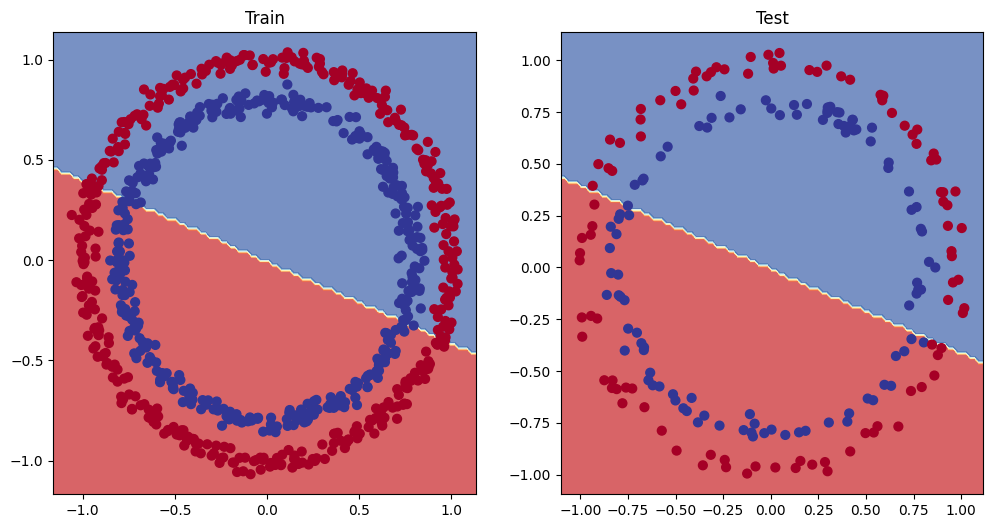

In [41]:
#Plot decision boundry of model

plt.figure(figsize =(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,Y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0,X_test,Y_test)


### since we are using linear layer that is the reason we have this one line trying to seperate two circles


## 5. Improving our model (from models prespective)

* We can add more layers
* Add more hidden units
* Fit for longer (epochs)
* Changing the activation functions
* Change the learning Rate (one can might face `Exploding Gradient Problem` Overshooting of our gradient Descent)
* Change the loss
* Change the optimizer


**Parameters** are the input values given to model.

**HyperParameters** are the values that we can change (as a Data scientists and ML Engineers) so they referred as Hyperparameters i.e Adding layer, loss functions etc

In [45]:
# Adding More hidden units
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)


  def forward(self, x):
    z = self.layer_1(x)
    z = self.layer_2(z)
    z = self.layer_3(z)
    return z

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
#Create a loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

#create an optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.1)

In [50]:
torch.manual_seed(42)
epochs = 1000

X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)
for epoch in range(epochs):
  model_1.train()
  Y_logits  = model_1(X_train).squeeze()
  Y_pred = torch.round(torch.sigmoid(Y_logits))
  loss = loss_fn(Y_logits, Y_train)
  acc = accuracy_fn(Y_true = Y_train, Y_pred= Y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, Y_test)
    test_acc = accuracy_fn(Y_true = Y_test, Y_pred = test_preds)


  if epoch % 100 == 0:
    print(f"Epoch no : {epoch} | Training Loss : {loss:.5f} | Training Accuracy : {acc:.2f}% | Testing Loss : {loss_test:.5f} | Accuracy Testing : {acc_test:.2f}%")



Epoch no : 0 | Training Loss : 0.69528 | Training Accuracy : 0.51% | Testing Loss : 0.69450 | Accuracy Testing : 0.46%
Epoch no : 100 | Training Loss : 0.69528 | Training Accuracy : 0.51% | Testing Loss : 0.69450 | Accuracy Testing : 0.46%
Epoch no : 200 | Training Loss : 0.69528 | Training Accuracy : 0.51% | Testing Loss : 0.69450 | Accuracy Testing : 0.46%
Epoch no : 300 | Training Loss : 0.69528 | Training Accuracy : 0.51% | Testing Loss : 0.69450 | Accuracy Testing : 0.46%
Epoch no : 400 | Training Loss : 0.69528 | Training Accuracy : 0.51% | Testing Loss : 0.69450 | Accuracy Testing : 0.46%
Epoch no : 500 | Training Loss : 0.69528 | Training Accuracy : 0.51% | Testing Loss : 0.69450 | Accuracy Testing : 0.46%
Epoch no : 600 | Training Loss : 0.69528 | Training Accuracy : 0.51% | Testing Loss : 0.69450 | Accuracy Testing : 0.46%
Epoch no : 700 | Training Loss : 0.69528 | Training Accuracy : 0.51% | Testing Loss : 0.69450 | Accuracy Testing : 0.46%
Epoch no : 800 | Training Loss : 0

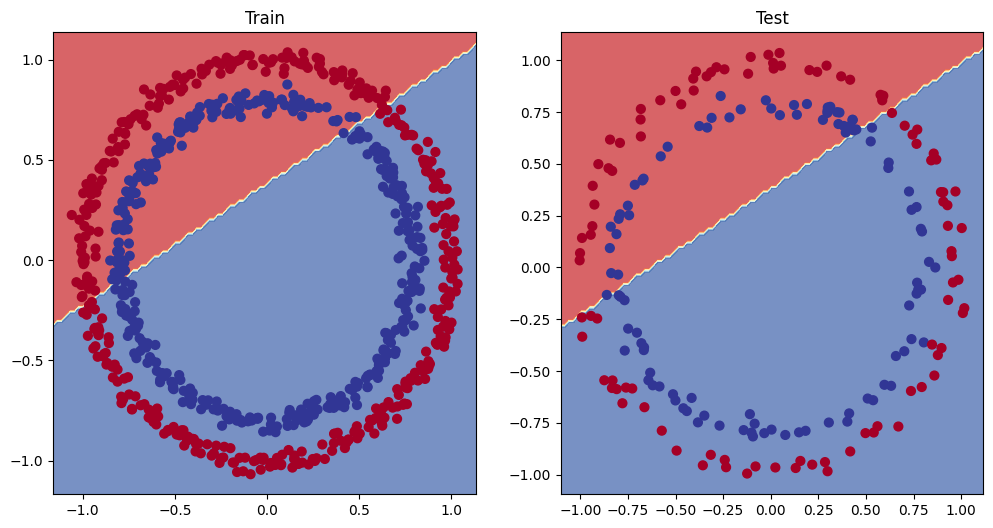

In [52]:
#Plot decision boundry of model

plt.figure(figsize =(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,Y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1,X_test,Y_test)


### since we are using linear layer that is the reason we have this one line trying to seperate two circles


## 6. The missing piece : Non Linearity

The model is unable to predict actual labels because we were using a linear model which was creating a stright line Instead we should be going for somthing non linear

### 6.1 Recreating non-linear data(red and blue circles)

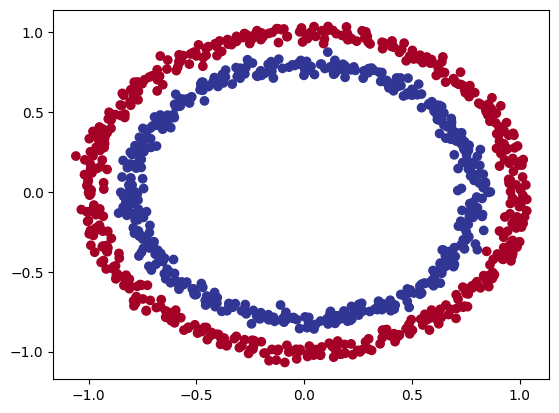

In [21]:
#Make and plot data

import matplotlib.pyplot as plt
import torch
from sklearn.datasets import make_circles
n_samples = 1000


X, y = make_circles(n_samples, noise = 0.03, random_state = 42)

plt.scatter(X[:, 0], X[:,1], c=y, cmap = plt.cm.RdYlBu)


In [22]:
# converting data to tensors and to train and test split
from sklearn.model_selection import train_test_split
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non linearity

* Non-Linear = Non straight line

In [23]:
# Building a model with non linear activation funcion
from torch import nn
class Circlemodel_V3(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features  = 10)
    self.layer_3 = nn.Linear(in_features=10, out_features = 1)
    self.relu = nn.ReLU()

  def forward(self,x):
    z = self.layer_1(x)
    z = self.relu(z)
    z= self.layer_2(z)
    z = self.relu(z)
    z= self.layer_3(z)
    return z


model_2 = Circlemodel_V3()
model_2.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [24]:
#setup loss and optimizer

loss_fn = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.1
                            )
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 6.3 Training a model with non linearity


In [26]:
torch.manual_seed(42)
#device agnostic code

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(0, epochs):
  model_2.train()
  y_logits  = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(Y_true = y_train, Y_pred = y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss  = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(Y_true = y_test, Y_pred = test_pred)

  if epoch % 100 ==0:
        print(f"Epoch no : {epoch} | Training Loss : {loss:.5f} | Training Accuracy : {acc:.2f}% | Testing Loss : {test_loss:.5f} | Accuracy Testing : {test_acc:.2f}%")





Epoch no : 0 | Training Loss : 0.69289 | Training Accuracy : 0.50% | Testing Loss : 0.69312 | Accuracy Testing : 0.50%
Epoch no : 100 | Training Loss : 0.69114 | Training Accuracy : 0.53% | Testing Loss : 0.69101 | Accuracy Testing : 0.53%
Epoch no : 200 | Training Loss : 0.68976 | Training Accuracy : 0.53% | Testing Loss : 0.68938 | Accuracy Testing : 0.56%
Epoch no : 300 | Training Loss : 0.68793 | Training Accuracy : 0.53% | Testing Loss : 0.68721 | Accuracy Testing : 0.56%
Epoch no : 400 | Training Loss : 0.68513 | Training Accuracy : 0.53% | Testing Loss : 0.68408 | Accuracy Testing : 0.56%
Epoch no : 500 | Training Loss : 0.68097 | Training Accuracy : 0.53% | Testing Loss : 0.67936 | Accuracy Testing : 0.56%
Epoch no : 600 | Training Loss : 0.67508 | Training Accuracy : 0.55% | Testing Loss : 0.67277 | Accuracy Testing : 0.56%
Epoch no : 700 | Training Loss : 0.66648 | Training Accuracy : 0.58% | Testing Loss : 0.66310 | Accuracy Testing : 0.59%
Epoch no : 800 | Training Loss : 0

### 6.4 Evaluating a model trained with non-linear activation functions


In [30]:
# Makes Predictions
model_2.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_2(X_test))).squeeze()

y_preds[:10], y_test[0:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

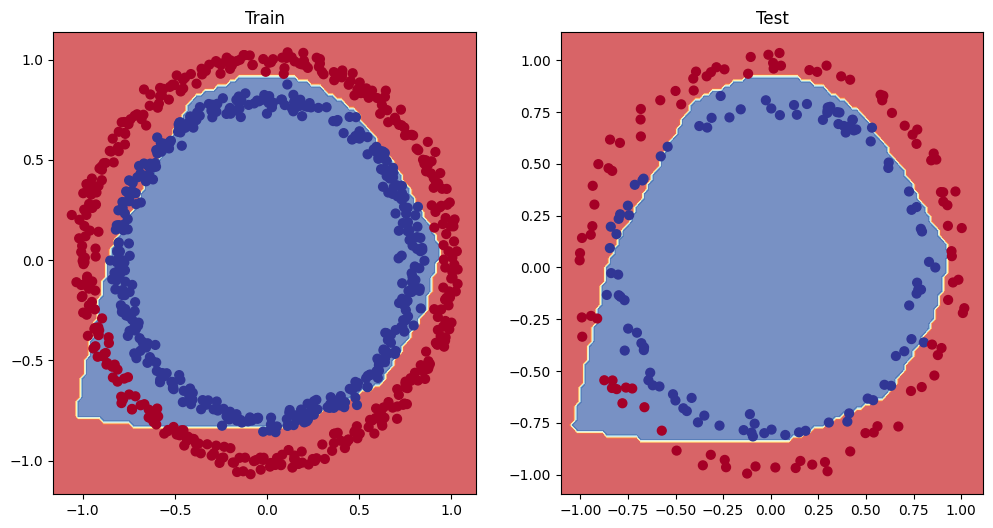

In [33]:
# Plot Decision boundries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test )


## 7. Replication non linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and patterns on its own
and these tools are linear and non linear functions



In [34]:
#Create a tensor

A = torch.arange(-10,10,1, dtype=torch.float32)
A.dtype

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

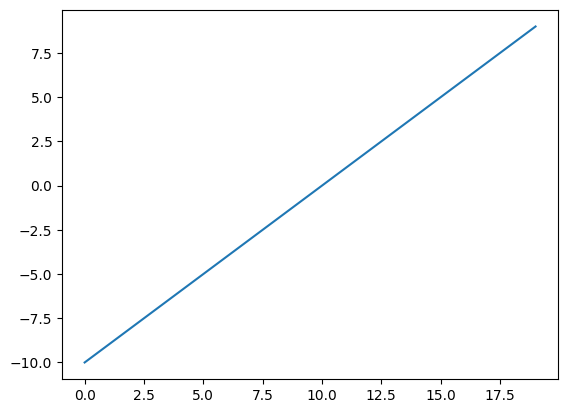

In [35]:
plt.plot(A)

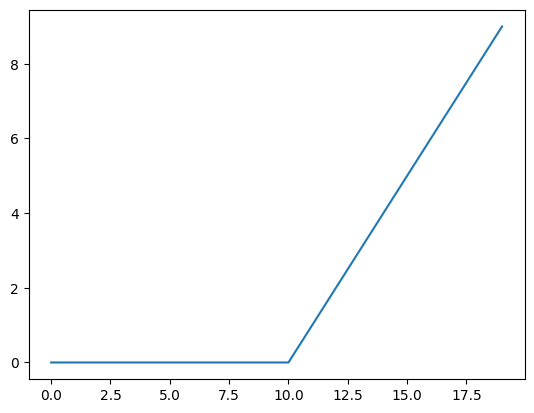

In [36]:
plt.plot(torch.relu(A))

In [37]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0),x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

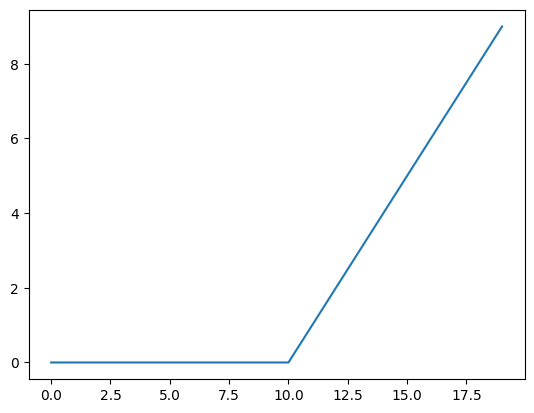

In [38]:
plt.plot(relu(A))

In [39]:
# Now let's do the same for sigmoid

def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

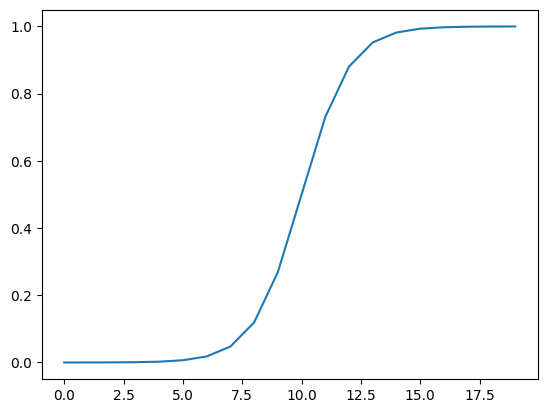

In [43]:
#torch sigmoid function
plt.plot(torch.sigmoid(A))

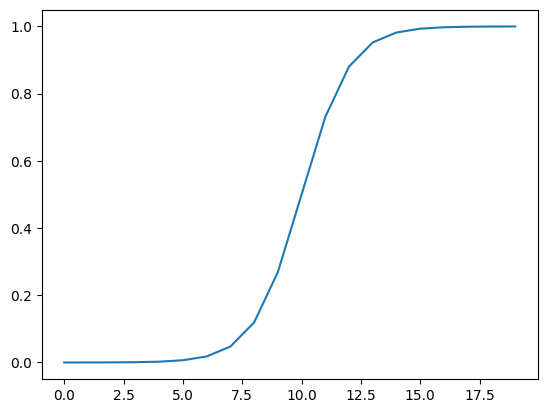

In [44]:
#our sigmoid function

plt.plot(sigmoid(A))

## 8. Putting it all together with Multi-class Classification

Key difference between binary and multiclass classification is :

* sigmoid Activation function -> Softmax activation function
* Binary Cross Entropy loss function -> Cross Entropy Loss Function

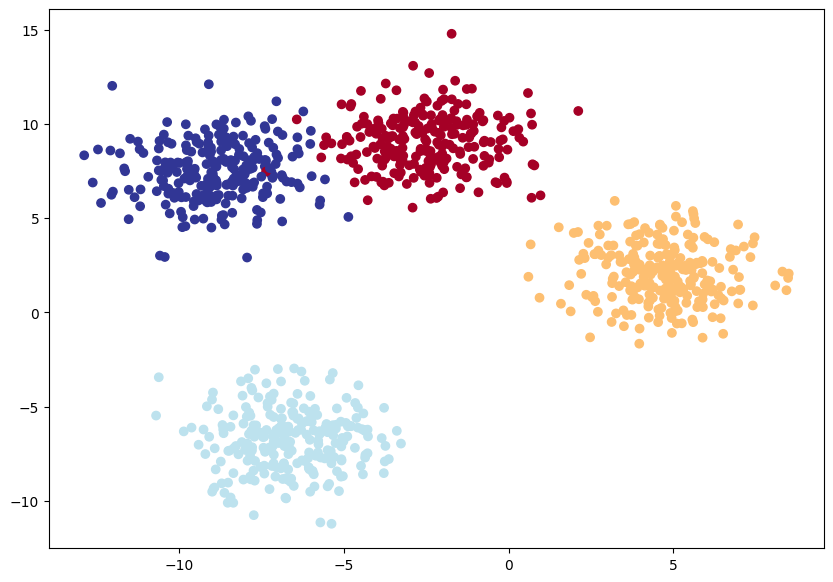

In [49]:
import torch
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#Setting up Hyperparameters for data creation

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

#1. Create Multi-class Data

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std =1.5,
                            random_state=RANDOM_SEED)


X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.float32)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size = 0.2,
                                                                        random_state = RANDOM_SEED)

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob, cmap=plt.cm.RdYlBu);


In [ ]:
#device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
device

### 8.2 Building a multi-class classification model in PyTorch

In [56]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features,hidden_units=8):
    """Initializes multi-class classification model.

    Args:
    input_features (int) : Number of input features in  the model
    output_features (int) : Number of output features (number of output classes)
    hidden_units(int) : Number of hidden units between layers, default 8

    returns:

    Examples :
    """
    super().__init__()
    self.liner_layer_stack = nn.Sequential(
    nn.Linear(in_features=input_features, out_features=hidden_units),
    nn.ReLU(),
    nn.Linear(in_features=hidden_units, out_features=hidden_units),
    nn.ReLU(),
    nn.Linear(in_features = hidden_units, out_features=output_features))


  def forward(self,x):
    return self.liner_layer_stack(x)


model_3 = BlobModel(input_features = 2, output_features=4).to(device)


In [58]:
#creating a loss fn
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model_3.parameters(), lr = 0.1)